In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

from skimage.feature import hog

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install -q kagglehub

In [3]:
import kagglehub

path = kagglehub.dataset_download("prathumarikeri/indian-sign-language-isl")
print("Path to dataset files:", path)

100%|██████████| 281M/281M [00:03<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prathumarikeri/indian-sign-language-isl/versions/1


In [4]:
!ls $path

Indian


In [5]:
!ls $path/Indian*

1  3  5  7  9  B  D  F	H  J  L  N  P  R  T  V	X  Z
2  4  6  8  A  C  E  G	I  K  M  O  Q  S  U  W	Y


In [7]:
DATASET_PATH = path + "/Indian"
IMG_SIZE = 64

In [8]:
images = []
labels = []

for label in os.listdir(DATASET_PATH):
  label_path = os.path.join(DATASET_PATH, label)
  if not os.path.isdir(label_path):
    continue
  for image_name in os.listdir(label_path):
    img_path = os.path.join(label_path, image_name)
    image = cv2.imread(img_path)
    if image is None:
      continue
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(gray)
    labels.append(label)
images = np.array(images)
labels = np.array(labels)

print("Total samples:", len(images))

Total samples: 42745


In [9]:
def coarse_signature(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    small = cv2.resize(img, (8, 8))
    return small.flatten()

signatures = np.array([coarse_signature(img) for img in images])

In [10]:
from sklearn.cluster import MiniBatchKMeans

N_GROUPS = max(len(images) // 10, 100)

kmeans = MiniBatchKMeans(
    n_clusters=N_GROUPS,
    random_state=84,
    batch_size=1024
)

group_ids = kmeans.fit_predict(signatures)

In [11]:
unique, counts = np.unique(group_ids, return_counts=True)
print("Number of groups:", len(unique))
print("Max group size:", counts.max())
print("Median group size:", np.median(counts))

Number of groups: 4218
Max group size: 74
Median group size: 9.0


In [12]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(
    n_splits=2,
    test_size=0.4,
    random_state=84
)

train_idx, test_idx = next(
    gss.split(images, labels, groups=group_ids)
)


In [13]:
x_train_images = images[train_idx]
x_test_images  = images[test_idx]

y_train_labels = labels[train_idx]
y_test_labels  = labels[test_idx]

In [14]:
train_groups = set(group_ids[train_idx])
test_groups  = set(group_ids[test_idx])

print("Group overlap:",
      len(train_groups.intersection(test_groups)))

Group overlap: 0


In [15]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_labels)
y_test_enc = le.transform(y_test_labels)

In [16]:
def extract_hog_batch(images):
    hog_features = []
    for image in images:
        feat = hog(
            image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2,2),
            block_norm='L2-Hys'
        )
        hog_features.append(feat)
    return np.array(hog_features)

x_train_hog = extract_hog_batch(x_train_images)
x_test_hog = extract_hog_batch(x_test_images)

In [17]:
scaler = StandardScaler()
x_train_hog = scaler.fit_transform(x_train_hog)
x_test_hog = scaler.transform(x_test_hog)

In [18]:
lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    multi_class='auto'
    )
lr.fit(x_train_hog, y_train_enc)

y_pred_lr = lr.predict(x_test_hog)
print("Logistic Regression Accuracy:", accuracy_score(y_test_enc, y_pred_lr))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9997619756024992


In [19]:
print(x_train_hog.shape)
print(x_train_hog.nbytes / 1024**2, "MB")

(25940, 1764)
349.1070556640625 MB


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
x_train_svm, y_train_svm = resample(
    x_train_hog,
    y_train_enc,
    n_samples=5000,
    random_state=84,
    stratify=y_train_enc
)

x_test_svm, y_test_svm = resample(
    x_test_hog,
    y_test_enc,
    n_samples=2000,
    random_state=84,
    stratify=y_test_enc
)

svm_sgd = SGDClassifier(
    loss="hinge",        # SVM
    alpha=1e-4,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

svm_sgd.fit(x_train_svm, y_train_svm)

y_pred_svm = svm_sgd.predict(x_test_svm)
print("Linear SVM (SGD) Accuracy:", accuracy_score(y_test_svm, y_pred_svm))


Linear SVM (SGD) Accuracy: 0.998


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 64
NUM_CLASSES = 35
BATCH_SIZE = 32
DATA_DIR = path + "/Indian"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6
)


Found 42745 files belonging to 35 classes.
Using 34196 files for training.
Found 42745 files belonging to 35 classes.
Using 8549 files for validation.
Epoch 1/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 215s 200ms/step - accuracy: 0.9301 - loss: 0.2881 - val_accuracy: 0.9998 - val_loss: 5.5271e-04
Epoch 2/6
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 256s 194ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 3/6
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 257s 189ms/step - accuracy: 0.9977 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 2.0800e-05
Epoch 4/6
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 217s 203ms/step - accuracy: 1.0000 - loss: 5.4577e-05 - val_accuracy: 1.0000 - val_loss: 3.0272e-06
Epoch 5/6
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 247s 189ms/step - accuracy: 1.0000 - loss: 2.6848e-06 - val_accuracy: 1.0000 - val_loss: 1.6740e-06
Epoch 6/6
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 265s 193ms/step - accuracy: 1.0000 - loss: 1.1115e-06 - val_accuracy: 1.0000 - val_loss: 9.8617e-07


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 1.0000 - loss: 7.8943e-07


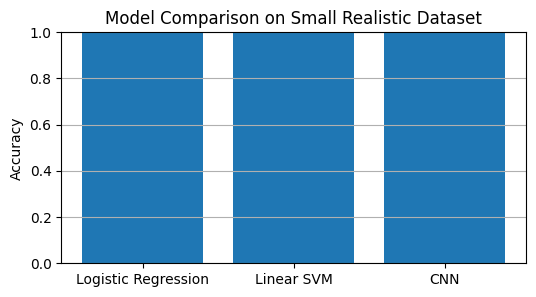

In [27]:
val_loss, val_acc = model.evaluate(val_ds)

models = ['Logistic Regression', 'Linear SVM', 'CNN']
accuracies = [accuracy_score(y_test_enc, y_pred_lr), accuracy_score(y_test_svm, y_pred_svm), val_acc]

plt.figure(figsize=(6,3))
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison on Small Realistic Dataset')
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()